# [A4] Neural Networks

In this exercise, you will use PyTorch to build a couple of supervised learning models:
* Logistic regression
* Shallow neural network
* Deep neural network ("Multilayer Perceptron")
* Convolutional neural network

Although PyTorch is a full-fledged deep learning framework with lots of components pre-built (many of them, such as different neural network layers, loss functions, and optimization algorithms in PyTorch's `.nn` submodule), you will build as much as possible from scratch in this exercise.

## 1: PyTorch Basics

Some of PyTorchs features are very similar to numpy. As you can see in the following code cell, you can define "arrays" very similar, but this time they are called ["Tensor"](https://en.wikipedia.org/wiki/Tensor_(machine_learning)).


In [ ]:
import torch
import numpy as np
import pandas as pd
from IPython.display import Latex
from matplotlib import pyplot as plt

torch.manual_seed(42)

x = torch.Tensor(2, 3, 4)
y = torch.zeros(3, 3)

print(f"Using torch {torch.__version__}")
print(f"x: {x}\nx.shape: {x.shape}\ny: {y}")

### 1.1: Basic Operations

It is also possible to perform operations on these tensors, often named the same as the numpy methods:


In [ ]:
x1 = torch.ones(3, 4)
x2 = torch.arange(3 * 4).reshape(3, 4)
sum = x1 + x2

print(f"  {x1}\n+ {x2}\n= {sum}")


You can also do more performant in-place operations that change the original tensor by adding a ` ` _ ` ` after a method name. 

Note how we need to explictly convert the data type of one of the two tensors, as this conversion is not done automatically.


In [ ]:
x2 = torch.arange(3 * 4).reshape(3, 4)
x2.add_(x1.long())
print(x2)


For matrix multiplication, we can use the [@ operator](https://pytorch.org/docs/stable/generated/torch.bmm.html?highlight=bmm#torch.bmm) or the [matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html) function.


In [ ]:
x3 = torch.tile(torch.arange(1, 4), (4, 1)).T
x4 = torch.arange(3 * 4).reshape(4, 3)
mult = x3 @ x4
print(f"  {x3}\n@ {x4}\n= {mult}\n= {torch.matmul(x3, x4)}")


### 1.2: Gradients

Another very important feature of PyTorch is the possibilty to calculate gradients (multiple values) and the derivative (single value) of functions we define. 

This is very useful when performing gradient descent for the backpropagation algorithm (for weight update in neural networks).

All tensors need to be of dtype float and need to have "requires_grad" enabled.

Let's do a simple example to understand the math behind this. You remember from school that the derivation of $a\cdot x^n $ is $ n\cdot a\cdot x^{n-1}$, so let's use

$$ f(x) = 4x^2 $$
$$ f'(x)=2 \cdot  4 \cdot  x^1 = 8x$$ 

Given e.g. $x=5$ we can now easily calculate by hand: 
$$f(5)=4\cdot 5^2=100$$
$$f'(5)=8\cdot 5=40$$

With PyTorch, we can calculate $f'(5)$  without even specifying the $f'(x)$ function first:


In [ ]:
x5 = torch.tensor(5.0, requires_grad=True)
fx5 = 4 * x5**2
fx5.backward()

display(Latex(f"$$ f({x5})={ fx5 } \\\\ f'({x5})={ x5.grad } $$"))


Partial derivatives can be calculated very similar:
$$ f(u, v) = 2u^4 + 3v^3 + 2uv $$

$$f'_u({u}, {v})=\frac{\partial f(u, v)}{\partial u} = 8u^3 + 2v$$
$$f'_v({u}, {v})=\frac{\partial f(u, v)}{\partial v} = 9v^2 + 2u$$


In [ ]:
u = torch.tensor(3.0, requires_grad=True)
v = torch.tensor(4.0, requires_grad=True)
fuv = 2 * u**4 + 3 * v**3 + 2 * u * v
fuv.backward()

display(
    Latex(
        f"$$ f({u},{v})={ fuv }       \\\\"
        f"   f'_u({u},{v})={ u.grad } \\\\"
        f"   f'_v({u},{v})={ v.grad } $$"
    )
)


We can apply our function to multiple values at once using non-scalar tensors.

Just like our good old graphical calculator did it back in the day, we can now calculate the derivation function values for multiple values of x.


In [ ]:
def plt_derivation(x, y, x_label="X"):
    plt.plot(x.detach().numpy(), y.detach().numpy(), label=f"$f({x_label})$")
    plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label=f"$f'({x_label})$")
    plt.legend()
    plt.xlabel(x_label)
    plt.gca().spines["left"].set_position("zero")
    plt.gca().spines["bottom"].set_position("zero")
    plt.gca().spines["right"].set_color("none")
    plt.gca().spines["top"].set_color("none")
    plt.grid()

    return plt.show()


In [ ]:
sample_range = 10
X5 = torch.linspace(-sample_range, sample_range, 21, requires_grad=True)
fX5 = 4 * X5**2
fX5.sum().backward()

plt_derivation(X5, fX5, x_label="X_5")


We can use the same approach to plot and calculate gradients of our more advanced function that takes two variables and has two derivations.

Note how we create a grid of (repeated) U and V values (feel free to print their values) to properly vectorize the ` ` fUV ` ` function (apply it over all combinations of $u$ and $v$ values).

To keep the gradient backtracking functionality, we are not allowed to use any non-PyTorch methods or for example regular ` `for` `-loops. This way, calculation will also be a lot faster.

By default, gradients will only be calculated for the starting nodes ("leafs") of the "computation graph" that PyTorch creates (U and V in this case). If we want to take a look at gradients of intermediate variables, we need to explicitly tell PyTorch to retain the calculated gradient for this variable.


In [ ]:
def plt_derivation_3d(u, v, y, u_label="U", v_label="V"):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")
    # ax.set_proj_type('ortho') # ax.view_init(elev=0, azim=-90, roll=0)
    for z_label, Z in {"f": y, "f'_u": u.grad, "f'_v": v.grad}.items():
        s = ax.plot_surface(
            X=u.detach().numpy(),
            Y=v.detach().numpy(),
            Z=Z.detach().numpy(),
            label=f"${z_label}({u_label},{v_label})$",
            alpha=0.4,
        )
        # quick fix for bug in some matplotlib versions:
        s._facecolors2d, s._edgecolors2d = s._facecolor3d, s._edgecolor3d
    ax.legend()
    ax.update({"xlabel": u_label, "ylabel": v_label, "zlabel": "f"})
    return plt.show()


In [ ]:
sample_range = 5
U = torch.linspace(-sample_range, sample_range, 21, requires_grad=True)
V = torch.linspace(-sample_range, sample_range, 21, requires_grad=True)

U_grid, V_grid = torch.meshgrid((U, V), indexing="xy")
U_grid.retain_grad()
V_grid.retain_grad()

fUV = 2 * U_grid**4 + 3 * V_grid**3 + 2 * U_grid * V_grid
fUV.sum().backward()

# plt_derivation_3d(U_grid, V_grid, fUV)


We can use this "autograd" functionality for any kind of tensors and chain operations as we want.

As you see, with every operation, a function ` ` grad_fn ` ` is passed to the resulting tensor, allowing us to perform the backwards step starting from the last element:


In [ ]:
x6 = torch.arange(3, dtype=torch.float32, requires_grad=True)
x7 = torch.arange(4, 7, dtype=torch.float32).requires_grad_()

a1 = x6 + x7
a2 = a1 + 2
a3 = a2**x6
print(f"  {x6}\n+ {x7}\n= {a1}\n+ 2\n= {a2}\n^ {x6}\n= {a3}")

a3.sum().backward()
print("-" * 53 + f"\ngrad(x6) = {x6.grad}\ngrad(x7) = {x7.grad}")


### 1.3: ✏️ Gradient Exercises

1. Calculate the derivative $f'(x)$ and $f'(4)$ of $ f(x) = 8x^4 + 4x^2 + x $ by hand using no code.


In [ ]:
# TODO: Answer
# f'(x) = 32x^3 + 8x + 1
# f'(4) = 32 * 4^3 + 8 * 4 + 1
# f'(4) = 2081

2. Implement $f(x)$ as a python method and calculate the derivative $f'(4)$ using PyTorch.


In [ ]:
# TODO: Implement
def f(x):
    return 8 * x**4 + 4 * x**2 + x

x = torch.tensor(4.0, requires_grad=True)
fx = f(x)
f4 = f(4)
f_derivat = fx.sum().backward()
print(f"f(4) = {f4}, f'(4) = {x.grad}")

3. Plot $f(x)$ and $f'(x)$ for $x\in[-15, 30]$.


In [ ]:
# TODO: Implement
x4 = torch.linspace(-15, 30, 28, requires_grad=True)
fx = f(x4)
fx.sum().backward()

plt_derivation(x4, fx, 'X')


## 2: Classifying the Iris Dataset

Using the basics learned above, we can now load the Iris dataset into PyTorch tensors.

### 2.1: ✏️ Load and Preprocess the Dataset

1. Load the Iris dataset and modify it to only seperate if something is of class _setosa_ or not. Call this _binary iris_ dataset _biris_ and the variables ``biris_X``, and ``biris_y``. Create a list ``biris_data`` of tuples containing the X values and the corresponding true/false label for each row.


In [ ]:
# TODO: Implement
biris = pd.read_csv(
    "data/iris.data",
    header=None,
    sep=",",
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "class"],
)

biris["biris_y"] = biris["class"].apply(lambda flower_class: 1 if "setosa" in flower_class else 0)
biris_X = biris.drop(columns=["class", "biris_y"]).values
biris_y = biris["biris_y"].values

biris_data = list(zip(biris_X, biris_y))
print(biris_data[0:5])

2. Convert ``biris_X`` and ``biris_y`` to PyTorch tensors.


In [ ]:
# TODO: Implement
biris_X = torch.from_numpy(biris_X)
biris_y = torch.from_numpy(biris_y)

### 2.2: ✏️ Logistic Regression

We want to perform a binary classification using a logistic regression and the sigmoid function. In a logistic regression, for each feature weights are learned.

1. Define a python method ``sigmoid(x)`` that implements the sigmoid function (using PyTorch methods). Compare it to the ``torch.sigmoid`` method for values $x\in[-5,5]$


In [ ]:
# TODO: Implement
# sigmoid function 1/1+e^(-x)
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [ ]:
x = torch.linspace(-5, 5, 100)
plt.plot(x.detach().numpy(), sigmoid(x).detach().numpy(), label="sigmoid")
plt.plot(x.detach().numpy(), torch.sigmoid(x).detach().numpy(), label="torch.sigmoid")
plt.legend()
plt.xlabel("X")
plt.ylabel("Sigmoid")
plt.title("Sigmoid function")
plt.grid()
plt.show()

2. For the logistic regression, we will need to pass both weights and data to the logistic function. Define a method ``logistic(w, x)`` that passes the result of a matrix multiplication of data and weights (``x @ w``) to the sigmoid function.


In [ ]:
# TODO: Implement
def logistic(w, x):
    return sigmoid(x @ w)

3. Call the logistic function using ``biris_X`` and random weights. Save the predictions in the variable ``y_pred_random``.


In [ ]:
# TODO: Implement
y_pred_random = []
for i in biris_X:
    random_w = torch.randn(4, requires_grad=True, dtype=torch.float64)
    y_pred_random.append(logistic(random_w, i))

4. Of course, in reality, the weights should be updated in an iterative process. For this, we will need a loss function. Implement the binary cross entropy loss $$ L_{BCE} = - \frac{1}{n} \sum^n_{i=1}\left(Y_i\cdot \log\hat{Y_i} + (1-Y_i) \cdot \log(1-\hat{Y_i})\right) $$ (with the predicted labels $\hat{Y}$ and the groundtruth labels $Y$) in a python method ``bce(y, y_hat)`` using PyTorch methods. Make use of built-in aggregation methods and vectorized methods instead of using ``for``-loops. Note: As calculating the BCE loss is known to be numerically unstable, clamp the output of each $\log$ to be $\geq - 100$ (read more [here](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).

In [ ]:
# TODO: Implement
def bce(y, y_hat):
    loss = -1 / len(y) * torch.sum(
        y * torch.clamp(torch.log(y_hat), min=-100) + (1 - y) * torch.clamp(torch.log(1 - y_hat), min=-100)
    )
    return loss

5. Evaluate the prediction ``y_pred_random`` using the bce loss function. 
Compare your own loss value to the output of the method ``torch.nn.functional.binary_cross_entropy(Y_hat, Y)`` (which requires ``Y`` to be of type float).


In [ ]:
# TODO: Implement
y_pred_random = torch.stack(y_pred_random)
loss_with_random_weights = bce(biris_y, y_pred_random)

print(f"Loss with random weights: {loss_with_random_weights}")

6. Create a new random weight tensor ``w``, but this time enable ``requires_grad``. For the given ``biris_X``, ``biris_y`` and the random weigths ``w`` create a combined loss function $L(X, y, w)$, similar to $f(U,V)$ earlier. Call ``backward()`` on this method instance and print partial derivative $L'_w(X, Y, w) = $ ``w.grad``.


In [ ]:
# TODO: Implement
# sample_range = 5
# U = torch.linspace(-sample_range, sample_range, 21, requires_grad=True)
# V = torch.linspace(-sample_range, sample_range, 21, requires_grad=True)
#
# U_grid, V_grid = torch.meshgrid((U, V), indexing="xy")
# U_grid.retain_grad()
# V_grid.retain_grad()
#
# fUV = 2 * U_grid**4 + 3 * V_grid**3 + 2 * U_grid * V_grid
# fUV.sum().backward()
# TODO this is returning none for some reason?
w = torch.randn(4, requires_grad=True, dtype=torch.float64)
def L(X,y,w):
    y_hat = logistic(w, X)
    loss = bce(y, y_hat)
    return loss

w_grad = L(biris_X, biris_y, w).backward()
print(w_grad)

7. Perform a single weight update step by subtracting the calculated gradient from the previous weight wector w. Predict ``y_pred_learned`` by running the logistic function with the updated weights. Evaluate the predictions using the bce loss function. If the loss increases, try multiplying the gradient with a learning rate, e.g. 0.001 before subtracting.

In [ ]:
# TODO: Implement
y_pred_learned = logistic(w, biris_X)


8. To perform multiple weight update steps, the gradient descent algorithm is used. Run the given method with the fixed learning rate $\alpha=0.01$ and randomly initialized weights to retrieve learned weights.


In [ ]:
def gd(modelfunc, lossfunc, X, y, w0, alpha, max_epochs=500):
    """Gradient Descent Algorithm

    This basic method is given here, you can implement and improve it by yourself in the optimization lab.

    For each epoch:
        - forward-step (predict labels and calculate loss)
        - backward-step (perform backpropagation)
        - update weights (create new weight tensor with reset gradient tracking)
        - log weight history

    """
    w = w0.clone().detach().requires_grad_()
    for k in range(max_epochs):
        pred = modelfunc(w, X)
        loss = lossfunc(y, pred)
        loss.backward()
        direction_of_descent = -w.grad
        w = w + alpha * direction_of_descent
        w.grad = None
        w.retain_grad()
    return w


In [ ]:
# TODO: Implement
random_weights = torch.randn(4, requires_grad=True, dtype=torch.float64)
learned_weights = gd(logistic, bce, biris_X, biris_y, random_weights, alpha=0.01)

9. Use the gradient-descent learned weights to predict ``y_pred_gd_``. Evaluate using the bce loss function (the error should be even lower).


In [ ]:
# TODO: Implement
y_pred_gd_ = []
for i in biris_X:
    y_pred_gd_.append(logistic(learned_weights, i))
y_pred_gd_ = torch.stack(y_pred_gd_)

loss_with_learned_weights = bce(biris_y, y_pred_gd_)

print(f"Loss with learned weights: {loss_with_learned_weights} | Loss with random weights: {loss_with_random_weights}")

10. When you round the output of the logistic function to either 0 or 1, you get the predicted class. Calculate the prediction accuracy for each set of predictions we had so far (``y_pred_random``, ``y_pred_learned`` and ``y_pred_gd``)


In [ ]:
# TODO: Implement
def accuracy(y, y_hat):
    y_hat = torch.round(y_hat)
    correct = torch.sum(y == y_hat).item()
    return correct / len(y)

print(f"Accuracy with random weights: {accuracy(biris_y, y_pred_random)} | Accuracy with learned weights: {accuracy(biris_y, y_pred_learned)} | Accuracy with GD weights: {accuracy(biris_y, y_pred_gd_)}")

11. Write a new gradient descent method ``gdi`` that saves the weights and the loss in each epoch (and returns lists of both in the end).


In [ ]:
def gdi(modelfunc, lossfunc, X, y, w0, alpha, max_epochs=500):
    # TODO: Implement
    w_history = []
    l_history = []
    w = w0.clone().detach().requires_grad_()
    for k in range(max_epochs):
        pred = modelfunc(w, X)
        loss = lossfunc(y, pred)
        loss.backward()
        direction_of_descent = -w.grad
        w = w + alpha * direction_of_descent
        w.grad = None
        w.retain_grad()
        w_history.append(w.clone().detach())
        l_history.append(loss.item())
    return w_history, l_history

12. Write a method ``visualize_error(errors)`` to visualize the loss in each epoch. Train ``gdi`` for 1000 epochs on biris and plot the error for each epoch.


In [ ]:
# TODO: Implement
def visualize_error(errors):
    plt.plot(errors)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.grid()
    plt.show()

_, l_history = gdi(logistic,bce, biris_X, biris_y, random_weights, alpha=0.01)
visualize_error(l_history)

13. Train 50 epochs of gdi for different learning rates (at least 3), which ones work better than others? Create a method ``visualize_loss_multi`` that takes a list of tuples ``(lr, loss_history)`` as input and visualize the different loss curves.


In [ ]:
# TODO: Implement
def visualize_loss_multi(learn_history):
    plt.figure(figsize=(10, 5))
    for i in range(len(learn_history)):
        plt.plot(learn_history[i][1], label=f"lr={learn_history[i][0]}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()
    plt.grid()
    plt.show()

lr_list = [0.001, 0.01, 0.1]
learn_history = []
for lr in lr_list:
    _, l_history = gdi(logistic, bce, biris_X, biris_y, random_weights, lr, max_epochs=50)
    learn_history.append([lr, l_history])
visualize_loss_multi(learn_history)


### 2.3: ✏️ Shallow neural network for Iris Dataset

A shallow neural network has exactly one hidden (fully-connected) layer between the input and output layers.

We therefore train two "layers" of weights, one connecting each input feature to each neuron of the hidden layer and one connecting each hidden layer neuron to the final output layer, which in our case consists of only one neuron.

In [ ]:
n_hidden_neuron = 10
n_features = biris_X.shape[1]

1. Initialize the two random weight tensors ``w1`` and ``w2``. Note: These `w` matrices need to be transposed compared to the lecture. Here, `n_features` is the number of rows of the tensor.

In [49]:
# TODO: Implement
w1 = torch.randn(n_features, n_hidden_neuron, requires_grad=True, dtype=torch.float64)

w2 = torch.randn(n_features, n_hidden_neuron, requires_grad=True, dtype=torch.float64)
print(w1)

tensor([[ 2.0503, -0.0618,  1.4856,  1.8505,  0.6391, -0.2124, -0.0208, -0.2427,
          0.8122,  1.1873],
        [ 0.9382,  1.5264, -0.0879,  0.1696, -0.3621,  1.3294, -0.4420,  0.8585,
          0.7087,  1.1691],
        [-0.5051,  0.5503, -1.2646, -1.1282, -1.3123,  0.1186, -0.4804,  1.2400,
         -0.8043,  0.2274],
        [ 2.9369,  0.9657,  0.2063,  1.9951, -0.7284, -0.3240, -0.6191,  0.5054,
          0.8523, -0.9385]], dtype=torch.float64, requires_grad=True)


2. Define a python method to calculate the outputs of the neural network (predictions). 
This is quite easy, just predict like you previously did, but chain the output of the first layer to the second layer and use w1 and w2 respectively. 
[Squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) the output to remove unnecessary lists.

In [56]:
def nn_shallow(w1, w2, x):
    w1 = torch.transpose(w1, 0, 1)
    x = torch.transpose(x, 0, 1)
    x = torch.matmul(w1, x) # x @ w1 first layer
    x = torch.sigmoid(x) # apply sigmoid activation function

    x = torch.matmul(w2, x) # x @ w2 second layer
    x = torch.sigmoid(x) # apply sigmoid activation function

    # squeeze output to remove unnecessary lists
    x = torch.squeeze(x)
    return x

3. Run your shallow network on biris and the two random weights. Print the output shape

In [60]:
# TODO: Implement
shallow_pred = nn_shallow(w1, w2, biris_X)
shallow_pred.shape

torch.Size([4, 150])

4. Calculate BCE loss on these predictions

In [61]:
# TODO: Implement
bce(biris_y, shallow_pred)

tensor(5.1204, dtype=torch.float64, grad_fn=<MulBackward0>)

5. Create a copy of the gradient descend ``gdi`` method called ``gdi_two_w`` to allow updating both weights w1 and w2 (using the respective gradients). It will return the history for both weights separately.

In [66]:
# TODO: Implement
def gdi_two_w(modelfunc, lossfunc, X, y, w1_0, w2_0, alpha, max_epochs=500):
    w1_history = []
    w2_history = []
    l_history = []
    w1_0 = w1_0.clone().detach().requires_grad_()
    w2_0 = w2_0.clone().detach().requires_grad_()
    for k in range(max_epochs):
        pred = modelfunc(w1_0, w2_0, X)
        loss = lossfunc(y, pred)
        loss.backward()
        direction_of_descent = -w1_0.grad
        w1_0 = w1_0 + alpha * direction_of_descent
        w1_0.grad = None
        w1_0.retain_grad()
        direction_of_descent = -w2_0.grad
        w2_0 = w2_0 + alpha * direction_of_descent
        w2_0.grad = None
        w2_0.retain_grad()
        w1_history.append(w1_0.clone().detach())
        w2_history.append(w2_0.clone().detach())
        l_history.append(loss.item())
    return w1_history, w2_history, l_history

6. Initialize random weights with ``requires_grad=True`` and train 1000 epochs of ``gdi_two_w`` using your shallow network as ``modelfunc``, the biris dataset and a learning rate of 0.01.

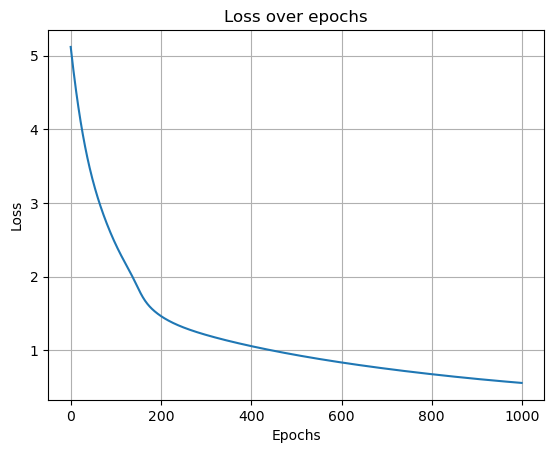

In [68]:
# TODO: Implement
w1_, w2_, loss = gdi_two_w(nn_shallow, bce, biris_X, biris_y, w1, w2, alpha=0.01, max_epochs=1000)
visualize_error(loss)

7. Train 120 epochs of ``gdi_two_w`` for different learning rates (at least 3). Does the error always go down with more epochs? Which learning rates work well?

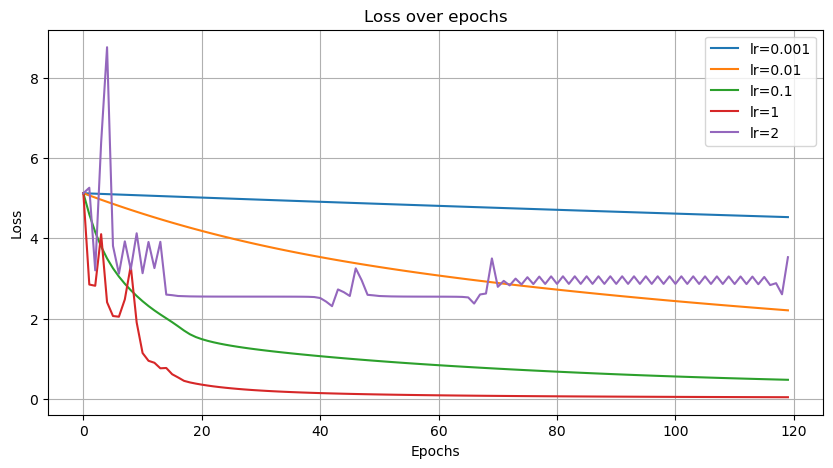

In [70]:
# TODO: Implement & Answer
learning_rates = [0.001, 0.01, 0.1, 1, 2]

learn_history = []
for lr in learning_rates:
    w1_, w2_, loss = gdi_two_w(nn_shallow, bce, biris_X, biris_y, w1, w2, alpha=lr, max_epochs=120)
    learn_history.append([lr, loss])

visualize_loss_multi(learn_history)

## 3: Classifying the Fashion MNIST Dataset
So far, we build everything by ourselves. PyTorch however also offers a wide variety of functions to define neural networks easier.
In this example, we create a PyTorch Module to define a simple neural network that will classify the fashion mnist data.

### 3.1: Load the Data into a tensor
Just as in the PCA exercise, we first load the data from disk into a dataframe and quickly visualize it.

,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,Pixel008,Pixel009,Pixel010,Pixel011,Pixel012,Pixel013,Pixel014,Pixel015,Pixel016,Pixel017,Pixel018,Pixel019,Pixel020,Pixel021,Pixel022,Pixel023,Pixel024,Pixel025,Pixel026,Pixel027,Pixel028,Pixel029,Pixel030,Pixel031,Pixel032,Pixel033,Pixel034,Pixel035,Pixel036,Pixel037,Pixel038,Pixel039,Pixel040,Pixel041,Pixel042,Pixel043,Pixel044,Pixel045,Pixel046,Pixel047,Pixel048,Pixel049,Pixel050,Pixel051,Pixel052,Pixel053,Pixel054,Pixel055,Pixel056,Pixel057,Pixel058,Pixel059,Pixel060,Pixel061,Pixel062,Pixel063,Pixel064,Pixel065,Pixel066,Pixel067,Pixel068,Pixel069,Pixel070,Pixel071,Pixel072,Pixel073,Pixel074,Pixel075,Pixel076,Pixel077,Pixel078,Pixel079,Pixel080,Pixel081,Pixel082,Pixel083,Pixel084,Pixel085,Pixel086,Pixel087,Pixel088,Pixel089,Pixel090,Pixel091,Pixel092,Pixel093,Pixel094,Pixel095,Pixel096,Pixel097,Pixel098,Pixel099,Pixel100,Pixel101,Pixel102,Pixel103,Pixel104,Pixel105,Pixel106,Pixel107,Pixel108,Pixel109,Pixel110,Pixel111,Pixel112,Pixel113,Pixel114,Pixel115,Pixel116,Pixel117,Pixel118,Pixel119,Pixel120,Pixel121,Pixel122,Pixel123,Pixel124,Pixel125,Pixel126,Pixel127,Pixel128,Pixel129,Pixel130,Pixel131,Pixel132,Pixel133,Pixel134,Pixel135,Pixel136,Pixel137,Pixel138,Pixel139,Pixel140,Pixel141,Pixel142,Pixel143,Pixel144,Pixel145,Pixel146,Pixel147,Pixel148,Pixel149,Pixel150,Pixel151,Pixel152,Pixel153,Pixel154,Pixel155,Pixel156,Pixel157,Pixel158,Pixel159,Pixel160,Pixel161,Pixel162,Pixel163,Pixel164,Pixel165,Pixel166,Pixel167,Pixel168,Pixel169,Pixel170,Pixel171,Pixel172,Pixel173,Pixel174,Pixel175,Pixel176,Pixel177,Pixel178,Pixel179,Pixel180,Pixel181,Pixel182,Pixel183,Pixel184,Pixel185,Pixel186,Pixel187,Pixel188,Pixel189,Pixel190,Pixel191,Pixel192,Pixel193,Pixel194,Pixel195,Pixel196,Pixel197,Pixel198,Pixel199,Pixel200,Pixel201,Pixel202,Pixel203,Pixel204,Pixel205,Pixel206,Pixel207,Pixel208,Pixel209,Pixel210,Pixel211,Pixel212,Pixel213,Pixel214,Pixel215,Pixel216,Pixel217,Pixel218,Pixel219,Pixel220,Pixel221,Pixel222,Pixel223,Pixel224,Pixel225,Pixel226,Pixel227,Pixel228,Pixel229,Pixel230,Pixel231,Pixel232,Pixel233,Pixel234,Pixel235,Pixel236,Pixel237,Pixel238,Pixel239,Pixel240,Pixel241,Pixel242,Pixel243,Pixel244,Pixel245,Pixel246,Pixel247,Pixel248,Pixel249,Pixel250,Pixel251,Pixel252,Pixel253,Pixel254,Pixel255,Pixel256,Pixel257,Pixel258,Pixel259,Pixel260,Pixel261,Pixel262,Pixel263,Pixel264,Pixel265,Pixel266,Pixel267,Pixel268,Pixel269,Pixel270,Pixel271,Pixel272,Pixel273,Pixel274,Pixel275,Pixel276,Pixel277,Pixel278,Pixel279,Pixel280,Pixel281,Pixel282,Pixel283,Pixel284,Pixel285,Pixel286,Pixel287,Pixel288,Pixel289,Pixel290,Pixel291,Pixel292,Pixel293,Pixel294,Pixel295,Pixel296,Pixel297,Pixel298,Pixel299,Pixel300,Pixel301,Pixel302,Pixel303,Pixel304,Pixel305,Pixel306,Pixel307,Pixel308,Pixel309,Pixel310,Pixel311,Pixel312,Pixel313,Pixel314,Pixel315,Pixel316,Pixel317,Pixel318,Pixel319,Pixel320,Pixel321,Pixel322,Pixel323,Pixel324,Pixel325,Pixel326,Pixel327,Pixel328,Pixel329,Pixel330,Pixel331,Pixel332,Pixel333,Pixel334,Pixel335,Pixel336,Pixel337,Pixel338,Pixel339,Pixel340,Pixel341,Pixel342,Pixel343,Pixel344,Pixel345,Pixel346,Pixel347,Pixel348,Pixel349,Pixel350,Pixel351,Pixel352,Pixel353,Pixel354,Pixel355,Pixel356,Pixel357,Pixel358,Pixel359,Pixel360,Pixel361,Pixel362,Pixel363,Pixel364,Pixel365,Pixel366,Pixel367,Pixel368,Pixel369,Pixel370,Pixel371,Pixel372,Pixel373,Pixel374,Pixel375,Pixel376,Pixel377,Pixel378,Pixel379,Pixel380,Pixel381,Pixel382,Pixel383,Pixel384,Pixel385,Pixel386,Pixel387,Pixel388,Pixel389,Pixel390,Pixel391,Pixel392,Pixel393,Pixel394,Pixel395,Pixel396,Pixel397,Pixel398,Pixel399,Pixel400,Pixel401,Pixel402,Pixel403,Pixel404,Pixel405,Pixel406,Pixel407,Pixel408,Pixel409,Pixel410,Pixel411,Pixel412,Pixel413,Pixel414,Pixel415,Pixel416,Pixel417,Pixel418,Pixel419,Pixel420,Pixel421,Pixel422,Pixel423,Pixel424,Pixel425,Pixel426,Pixel427,Pixel428,Pixel429,Pixel430,Pixel431,Pixel432,Pixel433,Pixel434,Pixel435,Pixel436,Pixel437,Pixel438,Pixel439,Pixel440,Pixel441,Pixel442,Pix

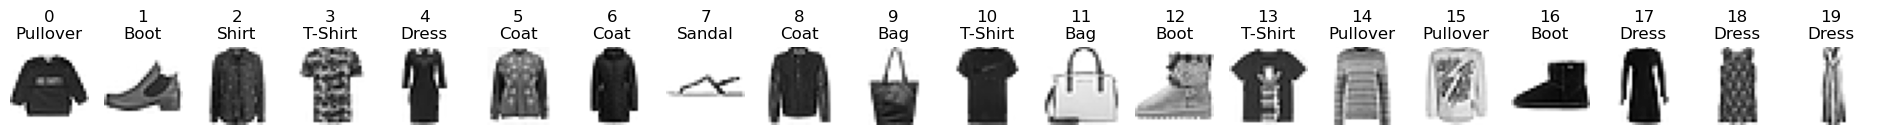

In [71]:
# Load Dataset
fm = pd.read_csv("data/fashion_mnist_train.csv.zip", index_col="Id")
fm_labels = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]
display(fm.head(2))

# Visualize Examples
num_samples = 20
ax = plt.subplots(nrows=1, ncols=num_samples, figsize=(24, 4))[1]
for i in range(num_samples):
    ax[i].set_axis_off()
    ax[i].set_title(f"{i}\n{fm_labels[fm.Category[i]]}")
    ax[i].imshow(fm.loc[i].values[1:].reshape((28,28)), cmap="gray_r")
plt.show()

Now, we transform it into PyTorch tensors:

In [72]:
fm_X = torch.tensor(fm.drop("Category", axis=1).values, dtype=torch.float32).reshape(-1, 1, 28, 28)
fm_y = torch.tensor(fm.Category.values.astype('int') , dtype=torch.long)

print(fm_X.shape, fm_y.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000])


### 3.2: Defining and Training a simple Classifier
Defining a neural network in PyTorch using the Module API will look like this: 

In [73]:
class SimpleClassifier(torch.nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        # self.linear1 = nn.Linear(num_inputs, num_hidden_neurons)
        # self.linear2 = torch.nn.Linear(num_hidden_neurons, num_outputs)
        self.conv1 = torch.nn.Conv2d(1, 4, 3, 1)
        self.conv2 = torch.nn.Conv2d(4, 8, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(1152, 128)
        self.fc2 = torch.nn.Linear(128, num_outputs)


    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.nn.functional.log_softmax(x, dim=1)
        return output


Our training loop will look like this:

In [74]:
def train_model(model, optimizer, X, y, loss_module, num_epochs=5):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        preds = model(X)
        preds = preds.squeeze(dim=1)
        loss = loss_module(preds, y)
        loss_history.append(loss.detach().numpy().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss after epoch {epoch}: {loss}")
    return loss_history

For running our training loop, we simply need to populate all the method parameters. For optimizer and loss, we can simply choose from what's built-in. Training the neural network will take about 3 minutes. 

In [ ]:
model = SimpleClassifier(num_outputs=10)
print(model)

loss_history = train_model(
    model,
    optimizer=torch.optim.SGD(model.parameters(), lr=0.1), # instead of GD
    X=fm_X,
    y=fm_y,
    loss_module=torch.nn.CrossEntropyLoss(), # instead of BinaryCrossEntropy
    num_epochs=10
)


SimpleClassifier(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
loss after epoch 0: 9.974296569824219
loss after epoch 1: 5.014455318450928
loss after epoch 2: 2.301744222640991
loss after epoch 3: 2.300595760345459
loss after epoch 4: 2.2988836765289307
loss after epoch 5: 2.2969155311584473


Everything the model learned is now contained in the ``model`` object, including weights.
The history of losses was saved in our training loop.

In [ ]:
print(list(model.state_dict().keys()), model.state_dict()["conv1.weight"][0][0][0])
print(loss_history)


visualize_error(loss_history)

### 4: ✏️ PyTorch model for Iris (Optional)
1. Create a PyTorch classifier class, model and training function for classifying either Iris or Biris. 

In [ ]:
# TODO: Implement (optional)

2. Compare your accuracy to the previous approach

In [ ]:
# TODO: Implement (optional)